# Практика 6 Загрузка данных из других источников

Существует множество различных источников данных о солнечном излучении. Вот некоторые из наиболее распространенных:

 [NSRDB](https://nsrdb.nrel.gov/data-viewer) - Национальная база данных солнечного излучения. Вы можете получить доступ к данным через веб-сайт для многих мест по всему миру или использовать их веб-API для загрузки данных программным путем. «API» — это «интерфейс прикладного программирования», а «веб-API» — это интерфейс программирования, который позволяет вам писать код для взаимодействия с веб-службами, такими как NSRDB.

Данные EPW — Energy Plus Weather доступны для многих мест по всему миру. Он находится в собственном файле формата («EPW»), поэтому вы не можете легко открыть его в программе для работы с электронными таблицами, такой как Excel, но вы можете использовать pvlib.iotools.read_epw(), чтобы поместить его в фрейм данных и использовать его.

PVGIS — бесплатные глобальные данные о погоде, предоставляемые Европейским союзом и полученные от многих государственных агентств, включая NSRDB. PVGIS также предоставляет веб-API. Вы можете получить данные TMY PVGIS, используя pvlib.iotools.get_pvgis_tmy().








### 6.1.Загрузка TMY с сайта NREL

In [1]:
import os
import inspect
import pandas as pd
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pvlib

ModuleNotFoundError: No module named 'pvlib'

In [ ]:
# Declare all variables as strings. Spaces must be replaced with '+', i.e., change 'John Smith' to 'John+Smith'.
# Define the lat, long of the location and the year
lat, lon, year = 56.2164, -95.1292, 2017
# You must request an NSRDB api key from the link above
api_key = 'NlWkkJymTdKhuFiTyK0eOComd96VheBQ0zpAdxjb'
# Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
attributes = 'ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle'
# Choose year of data
year = '2017'
# Set leap year to true or false. True will return leap day data if present, false will not.
leap_year = 'false'
# Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 30 & 60.
interval = '30'
# Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will use the local time zone of the data.
# NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'. SAM requires the data to be in the
# local time zone.
utc = 'false'
# Your full name, use '+' instead of spaces.
your_name = 'Fedor+Nepsha'
# Your reason for using the NSRDB.
reason_for_use = 'beta+testing'
# Your affiliation
your_affiliation = 'my+institution'
# Your email address
your_email = 'nepshafs@gmail.com'
# Please join our mailing list so we can keep you up-to-date on new developments.
mailing_list = 'true'

# Declare url string
url = 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
# Return just the first 2 lines to get metadata:
info = pd.read_csv(url, nrows=1)
# See metadata for specified properties, e.g., timezone and elevation
timezone, elevation = info['Local Time Zone'], info['Elevation']

In [ ]:
info

In [2]:
import plotly.express as px

data_geo = {'Latitude': [lat],
            'Longitude': [lon]}
# plotting map using plotly
fig = px.scatter_geo(data_geo, lat='Latitude', lon='Longitude',
                     hover_data=['Latitude', 'Longitude'],
                     projection="natural earth")

# setting title for the map
fig.update_layout(title='Coordinates', title_x=0.5)
# displaying the map
fig.show()

NameError: name 'lat' is not defined

In [21]:
# Return all but first 2 lines of csv to get data:
df = pd.read_csv('https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes), skiprows=2)
# Set the time index in the pandas dataframe:
df = df.set_index(pd.date_range('1/1/{yr}'.format(yr=year), freq=interval+'Min', periods=525600/int(interval)))
df=df.drop(['Year', "Month", 'Day', 'Hour', 'Minute'], axis=1)

In [22]:
df.tail()

,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
2017-12-31 21:30:00,0,0,0,0.5,-27,134.09
2017-12-31 22:00:00,0,0,0,0.5,-27,137.61
2017-12-31 22:30:00,0,0,0,0.5,-27,140.74
2017-12-31 23:00:00,0,0,0,0.5,-27,143.36
2017-12-31 23:30:00,0,0,0,0.5,-27,145.31


Text(0, 0.5, 'Irradiance [W/m$^2$]')

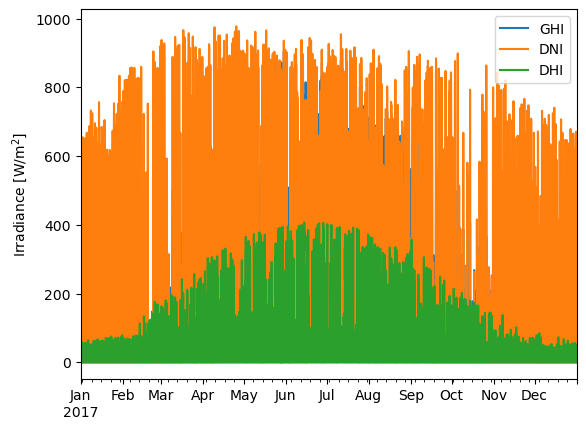

In [16]:
df[['GHI','DNI','DHI']].plot()
plt.ylabel('Irradiance [W/m$^2$]')

### 6.2. Загрузка TMY с сайта NREL (генерация кода на сайте)

In [27]:
import requests
import pandas as pd
import urllib.parse
import time

API_KEY = "ddrGdZff0T5DcF98iNuz4yroTAgXhvSuFMqhTqxn"
EMAIL = "nepshafs@gmail.com"
BASE_URL = "https://developer.nrel.gov/api/nsrdb/v2/solar/msg-iodc-download.json?"
POINTS = [
    '2782454'
]

def getDownloadURL():
    input_data = {
        'attributes': 'air_temperature,clearsky_dhi,clearsky_dni,clearsky_ghi,cloud_type,dew_point,dhi,dni,fill_flag,ghi,ozone,relative_humidity,solar_zenith_angle,surface_albedo,surface_pressure,total_precipitable_water,wind_direction,wind_speed',
        'interval': '30',

        'api_key': API_KEY,
        'email': EMAIL,
    }
    for name in ['2019']:
        print(f"Processing name: {name}")
        for id, location_ids in enumerate(POINTS):
            input_data['names'] = [name]
            input_data['location_ids'] = location_ids
            print(f'Making request for point group {id + 1} of {len(POINTS)}...')

            if '.csv' in BASE_URL:
                url = BASE_URL + urllib.parse.urlencode(data, True)
                # Note: CSV format is only supported for single point requests
                # Suggest that you might append to a larger data frame
                data = pd.read_csv(url)
                print(f'Response data (you should replace this print statement with your processing): {data}')
                # You can use the following code to write it to a file
                # data.to_csv('SingleBigDataPoint.csv')
            else:
                headers = {
                    'x-api-key': API_KEY
                }
                data = get_response_json_and_handle_errors(requests.post(BASE_URL, input_data, headers=headers))
                download_url = data['outputs']['downloadUrl']
                # You can do with what you will the download url
                print(data['outputs']['message'])
                print(f"Data can be downloaded from this url when ready: {download_url}")

                # Delay for 1 second to prevent rate limiting
                time.sleep(1)
            print(f'Processed')
    return download_url


def get_response_json_and_handle_errors(response: requests.Response) -> dict:
    """Takes the given response and handles any errors, along with providing
    the resulting json

    Parameters
    ----------
    response : requests.Response
        The response object

    Returns
    -------
    dict
        The resulting json
    """
    if response.status_code != 200:
        print(f"An error has occurred with the server or the request. The request response code/status: {response.status_code} {response.reason}")
        print(f"The response body: {response.text}")
        exit(1)

    try:
        response_json = response.json()
    except:
        print(f"The response couldn't be parsed as JSON, likely an issue with the server, here is the text: {response.text}")
        exit(1)

    if len(response_json['errors']) > 0:
        errors = '\n'.join(response_json['errors'])
        print(f"The request errored out, here are the errors: {errors}")
        exit(1)
    return response_json


In [28]:
download_url=getDownloadURL()

Processing name: 2019
Making request for point group 1 of 1...
File generation in progress. An email will be sent to nepshafs@gmail.com when the download is ready.
Data can be downloaded from this url when ready: https://mapfiles.nrel.gov/data/solar/b634b082f38ede2eb9fb6876752347b1.zip
Processed


In [29]:
download_url

'https://mapfiles.nrel.gov/data/solar/b634b082f38ede2eb9fb6876752347b1.zip'

In [30]:
import urllib.request
import os
from datetime import datetime
import zipfile

# Ввод URL для загрузки
url = download_url
save_dir = "DATA"
# Get the current date and time and format it as a string
now = datetime.now()
time_string = now.strftime("%Y-%m-%d_%H-%M-%S")

file_name = 'NREL_API.zip'
#file_name = f"NREL_{time_string}.zip"

# Создание директории если ее нет
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Скачать файл и сохранить в заданной директории
file_path = os.path.join(save_dir, file_name)
urllib.request.urlretrieve(url, file_path)

('DATA\\NREL_API.zip', <http.client.HTTPMessage at 0x1f990ccfd00>)

In [33]:
pd.read_csv('DATA\\2782454_56.89_60.66_2019.csv', skiprows=2)

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,2019,1,1,0,0,-16.0,0,0,0,7,...,0,0,0.300,83.70,125.47,0.87,987,0.5,259,1.3
1,2019,1,1,0,30,-15.9,0,0,0,7,...,0,0,0.300,83.00,121.42,0.87,987,0.5,260,1.3
2,2019,1,1,1,0,-15.8,0,0,0,7,...,0,0,0.300,84.28,117.33,0.87,987,0.5,261,1.3
3,2019,1,1,1,30,-15.7,0,0,0,6,...,0,0,0.300,83.58,113.25,0.87,987,0.5,261,1.3
4,2019,1,1,2,0,-15.6,0,0,0,7,...,0,0,0.300,84.16,109.21,0.87,988,0.5,261,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2019,12,31,21,30,-10.6,0,0,0,8,...,0,0,0.296,89.22,142.45,0.87,952,0.6,235,1.6
17516,2019,12,31,22,0,-10.6,0,0,0,4,...,0,0,0.297,90.06,139.81,0.87,952,0.6,237,1.6
17517,2019,12,31,22,30,-10.6,0,0,0,1,...,0,0,0.298,90.06,136.67,0.87,952,0.6,241,1.5
17518,2019,12,31,23,0,-10.6,0,0,0,7,...,0,0,0.298,89.84,133.17,0.87,953,0.6,245,1.5


In [34]:
# чтение файла
tmy_data, meta = pvlib.iotools.read_psm3('DATA\\2782454_56.89_60.66_2019.csv')

C:\Users\Nepsh\AppData\Roaming\Python\Python39\site-packages\pvlib\iotools\psm3.py:343: pvlibDeprecationWarning: PSM3 variable names will be renamed to pvlib conventions by default starting in pvlib 0.11.0. Specify map_variables=True to enable that behavior now, or specify map_variables=False to hide this warning.
  warnings.warn(


In [27]:
pvlib.iotools.read_psm3?

In [28]:
source_code=inspect.getsource(pvlib.iotools.read_psm3)
print(source_code)

def read_psm3(filename, map_variables=None):
    """
    Read an NSRDB PSM3 weather file (formatted as SAM CSV). The NSRDB
    is described in [1]_ and the SAM CSV format is described in [2]_.

    .. versionchanged:: 0.9.0
       The function now returns a tuple where the first element is a dataframe
       and the second element is a dictionary containing metadata. Previous
       versions of this function had the return values switched.

    Parameters
    ----------
    filename: str
        Filename of a file containing data to read.
    map_variables: bool
        When true, renames columns of the Dataframe to pvlib variable names
        where applicable. See variable VARIABLE_MAP.

    Returns
    -------
    data : pandas.DataFrame
        timeseries data from NREL PSM3
    metadata : dict
        metadata from NREL PSM3 about the record, see
        :func:`pvlib.iotools.parse_psm3` for fields

    See Also
    --------
    pvlib.iotools.parse_psm3, pvlib.iotools.get_psm3

   

In [29]:
pvlib.iotools.parse_psm3?

In [30]:
lines=inspect.getsource(pvlib.iotools.parse_psm3)
print(lines)

def parse_psm3(fbuf, map_variables=None):
    """
    Parse an NSRDB PSM3 weather file (formatted as SAM CSV). The NSRDB
    is described in [1]_ and the SAM CSV format is described in [2]_.

    .. versionchanged:: 0.9.0
       The function now returns a tuple where the first element is a dataframe
       and the second element is a dictionary containing metadata. Previous
       versions of this function had the return values switched.

    Parameters
    ----------
    fbuf: file-like object
        File-like object containing data to read.
    map_variables: bool
        When true, renames columns of the Dataframe to pvlib variable names
        where applicable. See variable VARIABLE_MAP.

    Returns
    -------
    data : pandas.DataFrame
        timeseries data from NREL PSM3
    metadata : dict
        metadata from NREL PSM3 about the record, see notes for fields

    Notes
    -----
    The return is a tuple with two items. The first item is a dataframe with
    the PSM3 tim

In [32]:
tmy_data.tail()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
2019-12-31 21:30:00+00:00,2019,12,31,21,30,-10.6,0.0,0.0,0.0,8,...,0,0.0,0.296,89.22,142.45,0.87,952.0,0.6,235.0,1.6
2019-12-31 22:00:00+00:00,2019,12,31,22,0,-10.6,0.0,0.0,0.0,4,...,0,0.0,0.297,90.06,139.81,0.87,952.0,0.6,237.0,1.6
2019-12-31 22:30:00+00:00,2019,12,31,22,30,-10.6,0.0,0.0,0.0,1,...,0,0.0,0.298,90.06,136.67,0.87,952.0,0.6,241.0,1.5
2019-12-31 23:00:00+00:00,2019,12,31,23,0,-10.6,0.0,0.0,0.0,7,...,0,0.0,0.298,89.84,133.17,0.87,953.0,0.6,245.0,1.5
2019-12-31 23:30:00+00:00,2019,12,31,23,30,-10.6,0.0,0.0,0.0,4,...,0,0.0,0.298,89.84,129.41,0.87,953.0,0.6,245.0,1.5


In [33]:
tmy_data.describe()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
count,17520.0,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,...,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.00000,17520.000000,17520.000000,17520.000000
mean,2019.0,6.526027,15.720548,11.500000,15.000000,1.177003,47.119292,279.506107,175.571062,4.121119,...,0.538527,93.646176,0.335332,84.229172,89.598917,0.479836,977.81718,1.237334,222.105422,1.149892
std,0.0,3.447950,8.796498,6.922384,15.000428,12.617481,59.728867,325.921096,247.721932,2.418522,...,1.189840,171.477561,0.053344,14.471145,27.443587,0.366990,10.00110,0.830548,83.735575,0.566561
min,2019.0,1.000000,1.000000,0.000000,0.000000,-39.300000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.213000,31.320000,33.450000,0.100000,945.00000,0.100000,0.000000,0.000000
25%,2019.0,4.000000,8.000000,5.750000,0.000000,-9.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.298000,78.537500,70.000000,0.130000,971.00000,0.600000,182.000000,0.700000
50%,2019.0,7.000000,16.000000,11.500000,15.000000,0.700000,0.000000,0.000000,0.000000,4.000000,...,0.000000,0.000000,0.335000,88.160000,89.190000,0.170000,978.00000,1.000000,245.000000,1.100000
75%,2019.0,10.000000,23.000000,17.250000,30.000000,11.700000,90.000000,602.000000,309.000000,7.000000,...,0.000000,102.000000,0.368000,95.030000,109.152500,0.870000,985.00000,1.800000,278.000000,1.500000
max,2019.0,12.000000,31.000000,23.000000,30.000000,31.500000,439.000000,957.000000,878.000000,12.000000,...,5.000000,878.000000,0.497000,100.000000,146.540000,0.870000,1007.00000,4.000000,360.000000,4.000000


### 6.3. Использование pvlib

In [34]:
pvlib.iotools.get_psm3?

In [35]:
source_code = inspect.getsource(pvlib.iotools.get_psm3)

In [12]:
print(source_code)

def get_psm3(latitude, longitude, api_key, email, names='tmy', interval=60,
             attributes=ATTRIBUTES, leap_day=None, full_name=PVLIB_PYTHON,
             affiliation=PVLIB_PYTHON, map_variables=None, timeout=30):
    """
    Retrieve NSRDB PSM3 timeseries weather data from the PSM3 API. The NSRDB
    is described in [1]_ and the PSM3 API is described in [2]_, [3]_, and [4]_.

    .. versionchanged:: 0.9.0
       The function now returns a tuple where the first element is a dataframe
       and the second element is a dictionary containing metadata. Previous
       versions of this function had the return values switched.

    Parameters
    ----------
    latitude : float or int
        in decimal degrees, between -90 and 90, north is positive
    longitude : float or int
        in decimal degrees, between -180 and 180, east is positive
    api_key : str
        NREL Developer Network API key
    email : str
        NREL API uses this to automatically communicate messages ba

In [35]:
df_abq, metadata = pvlib.iotools.get_psm3(
    latitude=32.87, longitude=-97,
    api_key='ddrGdZff0T5DcF98iNuz4yroTAgXhvSuFMqhTqxn',
    email='nepshafs@gmail.com',  # <-- any email works here fine
    names='tmy',
    interval=60)
metadata

C:\Users\Nepsh\AppData\Roaming\Python\Python39\site-packages\pvlib\iotools\psm3.py:343: pvlibDeprecationWarning: PSM3 variable names will be renamed to pvlib conventions by default starting in pvlib 0.11.0. Specify map_variables=True to enable that behavior now, or specify map_variables=False to hide this warning.
  warnings.warn(


{'Source': 'NSRDB',
 'Location ID': '697039',
 'City': '-',
 'State': '-',
 'Country': '-',
 'Latitude': 32.85,
 'Longitude': -97.02,
 'Time Zone': -6,
 'Elevation': 165,
 'Local Time Zone': -6,
 'Dew Point Units': 'c',
 'DHI Units': 'w/m2',
 'DNI Units': 'w/m2',
 'GHI Units': 'w/m2',
 'Temperature Units': 'c',
 'Pressure Units': 'mbar',
 'Wind Direction Units': 'Degrees',
 'Wind Speed Units': 'm/s',
 'Surface Albedo Units': 'N/A',
 'Version': '3.2.0'}

In [36]:
df_abq

,Year,Month,Day,Hour,Minute,GHI,Surface Albedo,Temperature,Pressure,Wind Direction,DNI,Wind Speed,Dew Point,DHI
2015-01-01 00:30:00-06:00,2015,1,1,0,30,0.0,0.16,0.0,1000.0,23.0,0.0,1.6,-3.0,0.0
2015-01-01 01:30:00-06:00,2015,1,1,1,30,0.0,0.16,0.0,1000.0,34.0,0.0,1.5,-3.0,0.0
2015-01-01 02:30:00-06:00,2015,1,1,2,30,0.0,0.16,0.0,1000.0,38.0,0.0,1.6,-2.0,0.0
2015-01-01 03:30:00-06:00,2015,1,1,3,30,0.0,0.16,0.0,1000.0,26.0,0.0,1.8,-2.0,0.0
2015-01-01 04:30:00-06:00,2015,1,1,4,30,0.0,0.16,0.0,1000.0,18.0,0.0,1.9,-2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:30:00-06:00,2013,12,31,19,30,0.0,0.16,0.0,1010.0,5.0,0.0,3.0,-3.0,0.0
2013-12-31 20:30:00-06:00,2013,12,31,20,30,0.0,0.16,0.0,1010.0,13.0,0.0,2.7,-3.0,0.0
2013-12-31 21:30:00-06:00,2013,12,31,21,30,0.0,0.16,0.0,1010.0,20.0,0.0,2.2,-3.0,0.0
2013-12-31 22:30:00-06:00,2013,12,31,22,30,0.0,0.16,0.0,1000.0,25.0,0.0,1.8,-3.0,0.0


In [38]:
# Note: TMY datasets are right-labeled hourly intervals, e.g. the
# 10AM to 11AM interval is labeled 11.  We should calculate solar position in
# the middle of the interval (10:30), so we subtract 30 minutes:
df_abq.index -= pd.Timedelta('30min')

In [39]:
df_abq.tail()

,Year,Month,Day,Hour,Minute,Temperature,Pressure,Wind Direction,DNI,Surface Albedo,GHI,Dew Point,DHI,Wind Speed
2013-12-31 19:00:00-06:00,2013,12,31,19,30,0.0,1010.0,5.0,0.0,0.16,0.0,-3.0,0.0,3.0
2013-12-31 20:00:00-06:00,2013,12,31,20,30,0.0,1010.0,13.0,0.0,0.16,0.0,-3.0,0.0,2.7
2013-12-31 21:00:00-06:00,2013,12,31,21,30,0.0,1010.0,20.0,0.0,0.16,0.0,-3.0,0.0,2.2
2013-12-31 22:00:00-06:00,2013,12,31,22,30,0.0,1000.0,25.0,0.0,0.16,0.0,-3.0,0.0,1.8
2013-12-31 23:00:00-06:00,2013,12,31,23,30,0.0,1000.0,24.0,0.0,0.16,0.0,-3.0,0.0,1.7


### 6.4. Данные с сайта NASA

In [37]:
from geopy.geocoders import Nominatim #Позволяет по координатам города вытаскивать данные
from timezonefinder import TimezoneFinder
from datetime import datetime

Названия параметров можно найти по [адресу](https://www.rdocumentation.org/packages/nasapower/versions/3.0.1/topics/parameters) и [общий справочник](https://power.larc.nasa.gov/#resources)

In [38]:
def getDataNasa(city, start, end):
    """Функция загрузки погодных данных NASA для региона."""

    geolocator = Nominatim(user_agent="user")
    location = geolocator.geocode(city)
    tf = TimezoneFinder()
    loc = (location.latitude, location.longitude)
    timezone = tf.timezone_at(lng=location.longitude, lat=location.latitude)
    locations = [(location.latitude, location.longitude)]
    latitude = location.latitude
    longitude = location.longitude
    altitude = location.altitude
    parameters = 'WS10M,ALLSKY_SFC_SW_DIFF,WS50M,T2M,PS,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI,RH2M,CLRSKY_KT'
    #Описание API по ссылке https://power.larc.nasa.gov/api/pages/?urls.primaryName=Hourly
    base_url_csv = "https://power.larc.nasa.gov//api/temporal/hourly/point?parameters={parameters}&community=RE&longitude={longitude}&latitude={latitude}&start={start}&end={end}&format=CSV"

    filename = city+'_'+str(start)+'_'+str(end)+'_NASA_Data.csv' #Наименование файла
    file_path = os.path.join('DATA', filename)
    for latitude, longitude in locations:
        api_request_url = base_url_csv.format(parameters=parameters, longitude=longitude, latitude=latitude, start=start, end=end)
        response = requests.get(url=api_request_url, verify=True, timeout=30.00)
        open(file_path, "wb").write(response.content)
    print(filename)
    return filename

In [39]:
filename=getDataNasa('Ekaterinburg', 20200101, 20201230)

Ekaterinburg_20200101_20201230_NASA_Data.csv


In [40]:
def NASAparser (filename):
    custom_datetime = lambda x: datetime.strptime(x, '%d %m %Y %H')
    df = pd.read_csv('DATA\\'+filename, skiprows=17, encoding='utf-8', parse_dates={ 'Date_Time': ['DY', 'MO', 'YEAR', 'HR'] }, date_parser=custom_datetime, index_col='Date_Time')
    df.rename(columns = {'T2M':'Temp','PS':'Pressure',
                         'ALLSKY_SFC_SW_DWN': 'GHI',
                         'ALLSKY_SFC_SW_DIFF': 'DHI',
                         'RH2M':'Relative_humidity',
                         'ALLSKY_SFC_SW_DNI': 'DNI',
                         'CLRSKY_KT': 'Clear index',
                         'WS50M':'Wind Speed 50M',
                         'WS10M':'Wind Speed 10M'},
              inplace = True)
    df.index.rename('Time')
    return df

In [42]:
df_NASA=NASAparser(filename)

In [43]:
df_NASA.describe()

,Wind Speed 10M,DHI,Wind Speed 50M,Temp,Pressure,GHI,DNI,Relative_humidity,Clear index
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,3.019016,62.130946,5.179842,2.583709,98.131264,124.241526,132.065247,86.635918,-486.991447
std,1.275367,89.994282,1.954700,12.229092,1.152833,191.415462,220.791145,16.503356,499.678227
min,0.120000,0.000000,0.180000,-27.820000,94.500000,0.000000,0.000000,27.000000,-999.000000
25%,2.110000,0.000000,3.890000,-7.600000,97.420000,0.000000,0.000000,79.810000,-999.000000
50%,2.860000,7.605000,5.180000,2.105000,98.070000,8.160000,13.575000,94.810000,0.270000
75%,3.750000,98.192500,6.350000,11.960000,98.940000,186.592500,158.305000,98.380000,0.640000
max,9.070000,461.510000,13.570000,35.480000,101.500000,874.860000,993.100000,100.000000,0.820000


In [44]:
df_NASA.shape[1]

9

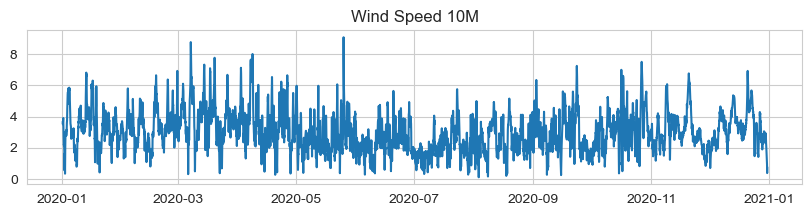

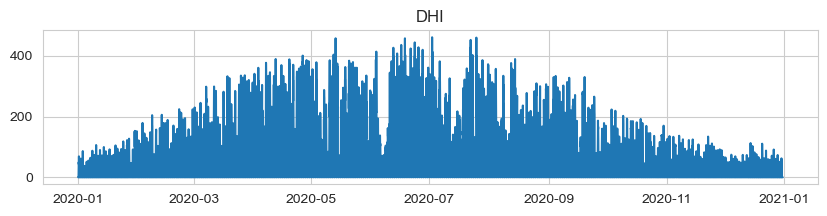

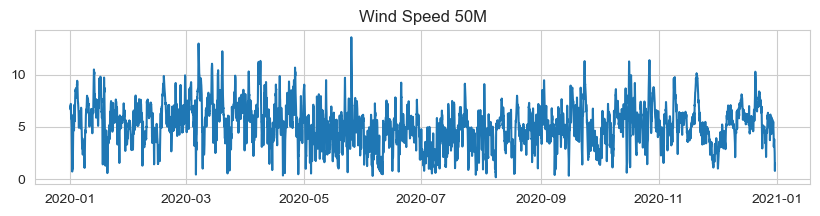

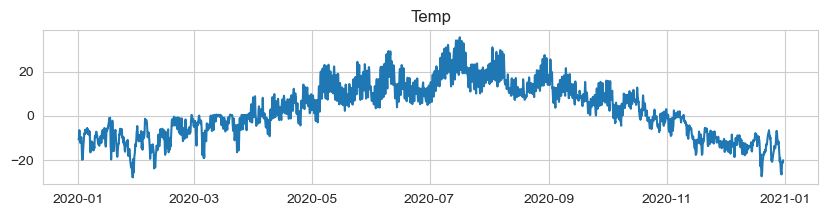

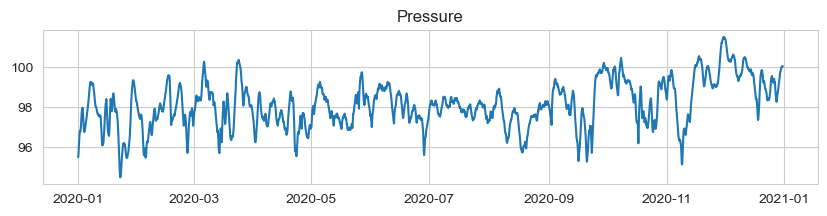

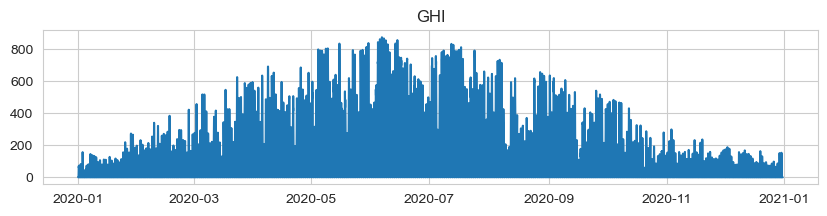

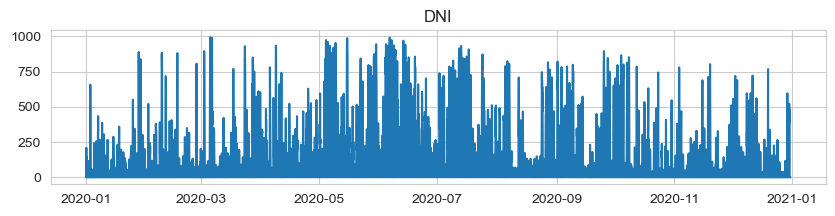

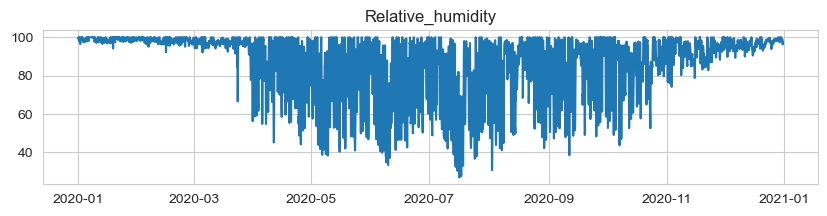

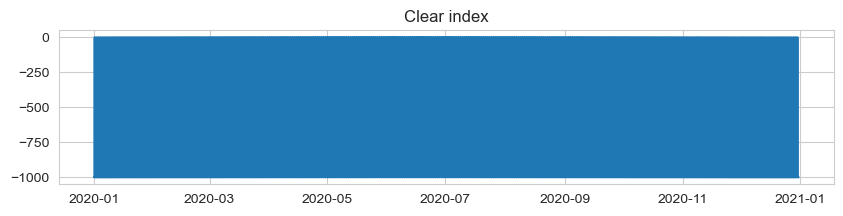

In [45]:
#Выведем графики для всех величин
for i in range (0, df_NASA.shape[1]):
    plt.figure(figsize=(10,2))
    plt.title(df_NASA.columns[i])
    plt.plot(df_NASA[df_NASA.columns[i]])
    plt.show()

## 6.5. Работа с  solcast

#### Прогнозы погоды (старый метод)

In [53]:
import requests
import json
import pandas as pd

# Зададим API key (см личный кабинет) и URL
api_key = 'G5khXg7r40xAo6RNPyq3lYExxexRLkRv'
url = 'https://api.solcast.com.au'

# Зададим долготу и широту для искомой локации
latitude = 44.96
longitude = 37.28

# Зададим начальный и конечный период для прогноза (необязательно)
start = '2023-04-05T00:00:00Z'
end = '2023-04-05T23:59:59Z'


# Зададим параметры для API запроса
params = {
    'latitude': latitude,
    'longitude': longitude,
    'format': 'json',
    'api_key': api_key,
    'start': start,
    'end': end
}

# Направим запрос по REST API и получим ответ
response = requests.get(url + '/radiation/forecasts', params=params)

# Проверка на успешность запроса
if response.status_code == 200:
    # Парсинг получаемого ответа
    data = json.loads(response.text)
    #Сохраним как json
    with open('DATA\data.json', 'w') as f:
        json.dump(data, f)
    # Сохранение данных в виде датафрейма
    df = pd.DataFrame(data['forecasts'], columns=['period_end', 'ghi', 'dni', 'dhi'])
    df['period_end'] = pd.to_datetime(df['period_end'])

    print('Forecast data saved to DataFrame:')
    print(df.head())
else:
    # Вывести ошибку, если запрос неуспешен
    print('Error:', response.status_code)

{"forecasts":[{"ghi":0,"ghi90":0,"ghi10":0,"ebh":0,"dni":0,"dni10":0,"dni90":0,"dhi":0,"air_temp":12,"zenith":106,"azimuth":49,"cloud_opacity":39,"period_end":"2023-04-30T18:30:00.0000000Z","period":"PT30M"},{"ghi":0,"ghi90":0,"ghi10":0,"ebh":0,"dni":0,"dni10":0,"dni90":0,"dhi":0,"air_temp":12,"zenith":110,"azimuth":42,"cloud_opacity":38,"period_end":"2023-04-30T19:00:00.0000000Z","period":"PT30M"},{"ghi":0,"ghi90":0,"ghi10":0,"ebh":0,"dni":0,"dni10":0,"dni90":0,"dhi":0,"air_temp":12,"zenith":113,"azimuth":35,"cloud_opacity":37,"period_end":"2023-04-30T19:30:00.0000000Z","period":"PT30M"},{"ghi":0,"ghi90":0,"ghi10":0,"ebh":0,"dni":0,"dni10":0,"dni90":0,"dhi":0,"air_temp":12,"zenith":116,"azimuth":28,"cloud_opacity":33,"period_end":"2023-04-30T20:00:00.0000000Z","period":"PT30M"},{"ghi":0,"ghi90":0,"ghi10":0,"ebh":0,"dni":0,"dni10":0,"dni90":0,"dhi":0,"air_temp":11,"zenith":118,"azimuth":20,"cloud_opacity":28,"period_end":"2023-04-30T20:30:00.0000000Z","period":"PT30M"},{"ghi":0,"ghi90"

Посмотрим файл JSON

### Запрос для избранного места

In [65]:
# Set the API key and URL for the Solcast API
url = 'https://api.solcast.com.au/weather_sites/74e3-3166-84e1-9d4a/forecasts'

# Set the parameters for the API request
params = {
    'format': 'json',
    'api_key': api_key
}

# Send the API request and get the response
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = json.loads(response.text)
    #Сохраним как json
    with open('DATA\data_1.json', 'w') as f:
        json.dump(data, f)
    # Save the forecast data to a Pandas DataFrame
    df_solcast_forecast = pd.DataFrame(data['forecasts'], columns=['period_end', 'ghi', 'dni', 'dhi','air_temp', 'cloud_opacity'])
    df_solcast_forecast['period_end'] = pd.to_datetime(df_solcast_forecast['period_end'])
    #df_solcast_forecast.set_index('period_end')
else:
    # Print an error message if the request failed
    print('Error:', response.status_code)

Error: 429


In [64]:
df.head()

,period_end,ghi,dni,dhi
0,2023-04-30 18:30:00+00:00,0,0,0
1,2023-04-30 19:00:00+00:00,0,0,0
2,2023-04-30 19:30:00+00:00,0,0,0
3,2023-04-30 20:00:00+00:00,0,0,0
4,2023-04-30 20:30:00+00:00,0,0,0


In [177]:
df_timestamp=df.set_index('period_end')

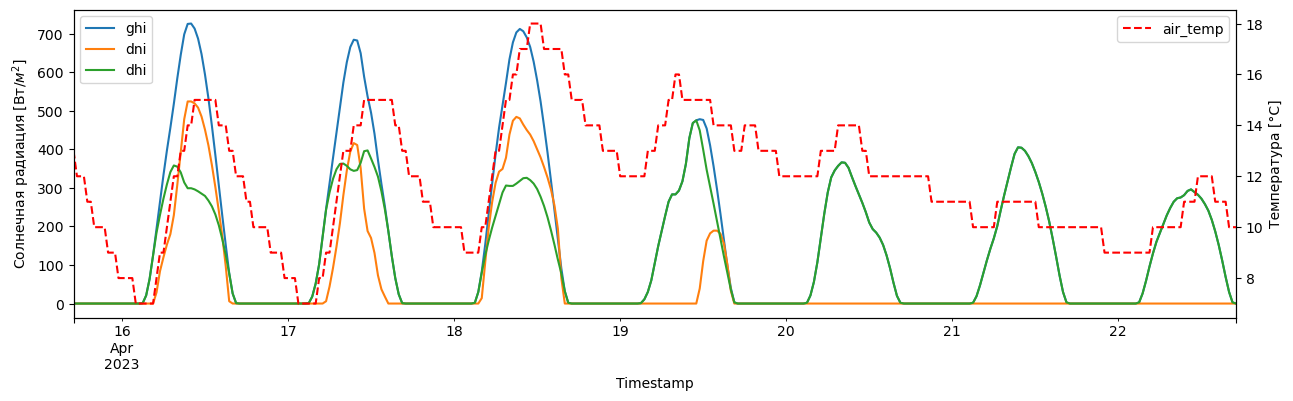

In [182]:
fig, ax1 = plt.subplots(figsize=(15, 4))
ax2=ax1.twinx()
df_timestamp[['ghi','dni','dhi']].plot(ax=ax1)
df_timestamp[['air_temp']].plot(ax=ax2, color="red", linestyle='dashed')
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Солнечная радиация [Вт/$м^2$]")
ax2.set_ylabel("Температура [°C]")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

### Запрос исторических данных

API не позволяет сделать запрос напрямую, возможна только выгрузка данных с [сайта](https://toolkit.solcast.com.au/historical/timeseries/request)

In [67]:
Solcast_historical=pd.read_csv('DATA/44.961239034914975_37.2849334653842_Solcast_PT60M.csv', index_col='PeriodStart')
Solcast_historical.drop(columns=['PeriodEnd', 'Period'])

,AirTemp,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SnowWater,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,AlbedoDaily
PeriodStart,,,,,,,,,,,,,,,,,,
2017-12-31T00:00:00Z,9.0,-74,0.2,7.6,0,0,0,0,0,0,16.3,91.3,0.0,1010.1,106,1.8,138,0.10
2017-12-31T01:00:00Z,9.3,-86,13.6,7.8,0,0,0,0,0,0,16.5,91.0,0.0,1010.1,114,2.6,128,0.10
2017-12-31T02:00:00Z,10.0,-97,38.0,8.5,0,0,0,0,0,0,16.9,90.7,0.0,1010.1,134,3.5,117,0.10
2017-12-31T03:00:00Z,10.7,-106,45.9,9.2,0,0,0,0,0,0,17.4,90.1,0.0,1010.2,149,4.5,107,0.10
2017-12-31T04:00:00Z,11.2,-116,23.1,9.6,0,0,0,0,0,0,17.7,90.2,0.0,1010.2,155,5.4,97,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29T19:00:00Z,5.0,39,81.8,-2.2,0,0,0,0,0,0,10.3,60.1,0.1,1014.1,331,8.8,124,0.07
2023-03-29T20:00:00Z,4.8,22,65.4,-2.3,0,0,0,0,0,0,10.0,60.1,0.1,1014.9,329,8.3,130,0.07
2023-03-29T21:00:00Z,4.6,2,66.8,-2.4,0,0,0,0,0,0,9.8,60.0,0.1,1015.5,327,8.0,132,0.07


In [68]:
Solcast_historical.describe()

,AirTemp,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SnowWater,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,AlbedoDaily
count,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000,45960.000000
mean,13.625263,-0.824347,28.154621,8.847117,62.954112,170.891340,96.905505,159.864056,180.871345,204.890970,17.937998,74.384569,0.120255,1013.576010,157.745213,5.048442,90.184030,0.115967
std,8.337237,101.566560,29.253735,7.346540,90.833717,292.353254,193.600785,243.790534,284.946004,306.530159,9.065465,13.050489,0.839175,6.749327,110.221770,2.452038,33.493372,0.022502
min,-8.300000,-180.000000,0.000000,-12.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.600000,29.000000,0.000000,988.900000,0.000000,0.100000,22.000000,0.070000
25%,7.000000,-91.000000,0.000000,3.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,65.900000,0.000000,1008.600000,55.000000,3.200000,65.000000,0.110000
50%,12.800000,0.000000,18.700000,8.400000,6.000000,0.000000,0.000000,6.000000,6.000000,6.000000,16.000000,76.500000,0.000000,1013.200000,159.000000,4.800000,90.000000,0.110000
75%,21.100000,89.000000,52.800000,14.800000,103.000000,239.000000,73.000000,243.000000,252.000000,343.000000,23.500000,84.600000,0.000000,1018.200000,247.000000,6.700000,116.000000,0.120000
max,31.800000,180.000000,97.000000,25.400000,528.000000,998.000000,881.000000,975.000000,1094.000000,996.000000,54.500000,99.700000,14.100000,1034.500000,360.000000,15.200000,158.000000,0.370000


In [69]:
Solcast_historical.isnull().sum().sum()

0

In [70]:
Solcast_historical.isna().sum().sum()

0

In [71]:
#Выведем данные за конкретный период
start_date = "2020-06-01"
end_date = "2020-06-02"
Solcast_historical_period = Solcast_historical[(Solcast_historical.index >= start_date) & (Solcast_historical.index <= end_date)]

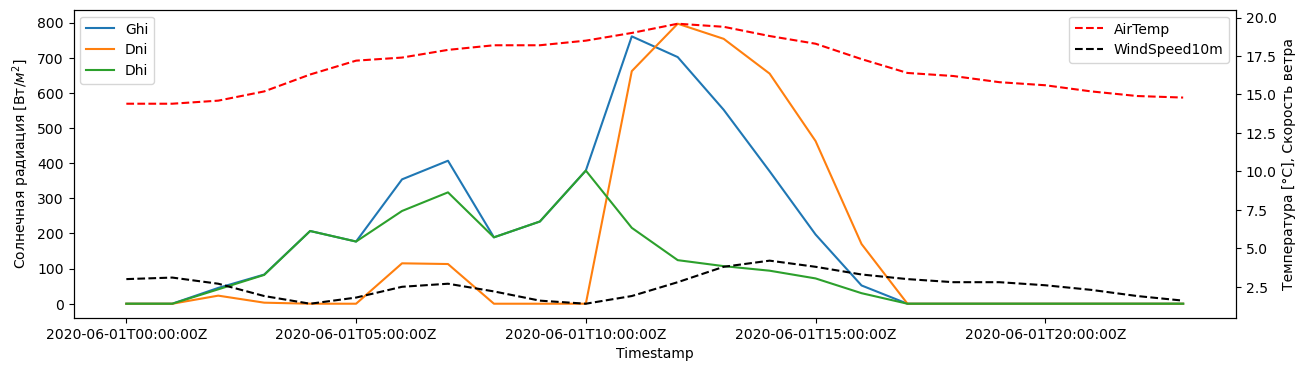

In [72]:
fig, ax1 = plt.subplots(figsize=(15, 4))
ax2=ax1.twinx()
Solcast_historical_period[['Ghi','Dni','Dhi']].plot(ax=ax1)
Solcast_historical_period[['AirTemp']].plot(ax=ax2, color='red', linestyle='dashed')
Solcast_historical_period[['WindSpeed10m']].plot(ax=ax2, color='black', linestyle='dashed')
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Солнечная радиация [Вт/$м^2$]")
ax2.set_ylabel("Температура [°C], Скорость ветра")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

### Задание

1) Сделайте запрос на solcast для получения PVPower , но для выбранных параметров солнечной электростанции (Pуст = 452 кВт, Pинв=500 кВт)
Longitude - 37.2849334653842
Latitude - 44.961239034914975
2) Скачайте исторический датасет для вышеуказанных координат

## 6.6. Работа с openweathermap

In [74]:
import requests

# Set the OpenWeatherMap API key
api_key = '4fbeefd20d8b7c96ba12f616cb27bc67'

# Set the city name and country code for the location you want to get the forecast for
latitude = 44.961239034914975
longitude = 37.2849334653842

# Set the units for the forecast (metric or imperial)
units = 'metric'

# Set the API endpoint URL
url = f'http://api.openweathermap.org/data/2.5/forecast?lat={latitude}&lon={longitude}&units={units}&appid={api_key}'

# Send the API request and get the response
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Print the API response
    data = json.loads(response.text)
    #Сохраним как json
    with open('DATA\data_openweathermap.json', 'w') as f:
        json.dump(data, f)
else:
    # Print an error message if the request failed
    print('Error:', response.status_code)

In [113]:
json_formatted_str = json.dumps(data, indent=2)
print(json_formatted_str )

{
  "cod": "200",
  "message": 0,
  "cnt": 40,
  "list": [
    {
      "dt": 1682888400,
      "main": {
        "temp": 11.3,
        "feels_like": 10.73,
        "temp_min": 11.3,
        "temp_max": 11.35,
        "pressure": 1011,
        "sea_level": 1011,
        "grnd_level": 1011,
        "humidity": 86,
        "temp_kf": -0.05
      },
      "weather": [
        {
          "id": 803,
          "main": "Clouds",
          "description": "broken clouds",
          "icon": "04n"
        }
      ],
      "clouds": {
        "all": 72
      },
      "wind": {
        "speed": 10.68,
        "deg": 200,
        "gust": 13.74
      },
      "visibility": 10000,
      "pop": 0,
      "sys": {
        "pod": "n"
      },
      "dt_txt": "2023-04-30 21:00:00"
    },
    {
      "dt": 1682899200,
      "main": {
        "temp": 11.18,
        "feels_like": 10.68,
        "temp_min": 11.13,
        "temp_max": 11.18,
        "pressure": 1011,
        "sea_level": 1011,
        "grnd_lev

In [110]:
from datetime import datetime

# прочитаем JSON
with open('DATA/data_openweathermap.json') as f:
    data = json.load(f)

#Создадим пустой лист для записи данных
openWeatherData =[]

#Чтение нужных полей в JSON
for item in data['list']:
    try:
        # запишем данные для каждой колонки
        timestamp = datetime.utcfromtimestamp(item['dt']).strftime('%Y-%m-%d %H:%M:%S')
        # парсим уровень main
        temp = item['main']['temp']
        feels_like = item['main']['feels_like']
        temp_min = item['main']['temp_min']
        temp_max = item['main']['temp_max']
        pressure = item['main']['pressure']
        humidity = item['main']['humidity']
        # парсим уровень weather
        weather_id = item['weather'][0]['id']
        weather_main = item['weather'][0]['main']
        weather_description = item['weather'][0]['description']
        weather_icon = item['weather'][0]['icon']
        clouds_all = item['clouds']['all']
        wind_speed = item['wind']['speed']
        wind_deg = item['wind']['deg']
        visibility = item['visibility']
        pop = item['pop']
        pod = item['sys']['pod']

        # append the row as a list to the rows list
        openWeatherData.append([timestamp, temp, feels_like, temp_min, temp_max, pressure, humidity,
                     weather_id, weather_main, weather_description, clouds_all,
                     wind_speed, wind_deg, visibility, pop, pod])
    except ValueError as e:
        # handle the error by printing a message and skipping the row
        print(f"Error: {e} - Skipping row.")
        continue

    # create a DataFrame from the rows list and specify column names
df = pd.DataFrame(openWeatherData, columns=['Timestamp', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
                                 'weather_id', 'weather_main', 'weather_description', 'clouds_all',
                                 'wind_speed', 'wind_deg', 'visibility', 'pop', 'pod'])
df.set_index('Timestamp')

,temp,feels_like,temp_min,temp_max,pressure,humidity,weather_id,weather_main,weather_description,clouds_all,wind_speed,wind_deg,visibility,pop,pod
Timestamp,,,,,,,,,,,,,,,
2023-04-30 21:00:00,11.30,10.73,11.30,11.35,1011,86,803,Clouds,broken clouds,72,10.68,200,10000,0.00,n
2023-05-01 00:00:00,11.18,10.68,11.13,11.18,1011,89,500,Rain,light rain,60,11.17,203,10000,0.28,n
2023-05-01 03:00:00,11.04,10.60,11.04,11.04,1011,92,500,Rain,light rain,100,11.85,199,10000,0.74,d
2023-05-01 06:00:00,10.82,10.36,10.82,10.82,1013,92,501,Rain,moderate rain,100,6.45,222,7673,0.95,d
2023-05-01 09:00:00,10.89,10.28,10.89,10.89,1015,86,500,Rain,light rain,100,2.21,254,10000,0.82,d
2023-05-01 12:00:00,11.20,10.54,11.20,11.20,1015,83,500,Rain,light rain,100,1.38,278,10000,0.82,d
2023-05-01 15:00:00,10.70,10.10,10.70,10.70,1016,87,500,Rain,light rain,99,3.78,324,10000,0.54,d
2023-05-01 18:00:00,10.50,9.64,10.50,10.50,1018,78,804,Clouds,overcast clouds,100,4.15,4,10000,0.47,n
2023-05-01 21:00:00,10.18,9.32,10.18,10.18,1018,79,500,Rain,light rain,100,2.55,356,10000,0.51,n


In [111]:
df

,Timestamp,temp,feels_like,temp_min,temp_max,pressure,humidity,weather_id,weather_main,weather_description,clouds_all,wind_speed,wind_deg,visibility,pop,pod
0,2023-04-30 21:00:00,11.30,10.73,11.30,11.35,1011,86,803,Clouds,broken clouds,72,10.68,200,10000,0.00,n
1,2023-05-01 00:00:00,11.18,10.68,11.13,11.18,1011,89,500,Rain,light rain,60,11.17,203,10000,0.28,n
2,2023-05-01 03:00:00,11.04,10.60,11.04,11.04,1011,92,500,Rain,light rain,100,11.85,199,10000,0.74,d
3,2023-05-01 06:00:00,10.82,10.36,10.82,10.82,1013,92,501,Rain,moderate rain,100,6.45,222,7673,0.95,d
4,2023-05-01 09:00:00,10.89,10.28,10.89,10.89,1015,86,500,Rain,light rain,100,2.21,254,10000,0.82,d
5,2023-05-01 12:00:00,11.20,10.54,11.20,11.20,1015,83,500,Rain,light rain,100,1.38,278,10000,0.82,d
6,2023-05-01 15:00:00,10.70,10.10,10.70,10.70,1016,87,500,Rain,light rain,99,3.78,324,10000,0.54,d
7,2023-05-01 18:00:00,10.50,9.64,10.50,10.50,1018,78,804,Clouds,overcast clouds,100,4.15,4,10000,0.47,n
8,2023-05-01 21:00:00,10.18,9.32,10.18,10.18,1018,79,500,Rain,light rain,100,2.55,356,10000,0.51,n
9,2023-05-02 00:00:00,9.20,8.74,9.20,9.20,1019,90,500,Rain,light rain,100,1.50,62,10000,0.56,n


Погодные идентификаторы, в том числе ID можно найти по [ссылке](https://openweathermap.org/weather-conditions)

## 6.7. Данные с rp5

In [ ]:
!pip install selenium

In [94]:
from selenium import webdriver
from datetime import  datetime, timedelta
import pandas as pd
import time
import re
import numpy as np
import os
import gzip
import shutil
import urllib
import urllib.request
import glob
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from time import sleep

In [95]:
from selenium.webdriver.common.by import By

#### Ретроспектива


In [170]:
def grab_weather_history(weather_region = 'Архив_погоды_в_Москве_(ВДНХ)', dt_from = datetime.now() - timedelta(days=3), dt_to = datetime.now(), outfolder_name='DATA'):

    # Зададим путь к папке
    temp_path = os.path.join( os.getcwd(), outfolder_name, 'weather_temp_folder')

    # Проверка наличия папки, если папка есть, то выполняется ее очистка
    if os.path.exists(temp_path) and os.path.isdir(temp_path):
        shutil.rmtree(temp_path)
    os.mkdir(temp_path)

    #Chrome options позволяет задать настройки браузера
    options = webdriver.ChromeOptions()
    #options.add_argument("--headless=new") #Невидимое окно браузера
    # Задается директория для загрузки по умолчанию
    prefs = {'download.default_directory': temp_path}
    options.add_experimental_option('prefs', prefs)

    with webdriver.Chrome(options=options) as driver:

        driver.implicitly_wait(120)  # seconds

        driver.get('http://www.rp5.ru/' + weather_region)
        time.sleep(1)
        #Выберем нужную таблицу
        if 'METAR' in weather_region:
            tab_selector = driver.find_element(By.ID, 'tabMetarDLoad')
        else:
            tab_selector = driver.find_element(By.ID, 'tabSynopDLoad')
        tab_selector.click()
        time.sleep(1)
        # Зададим даты в календаре
        input_dt1 = driver.find_element(By.ID, 'calender_dload')
        input_dt2 = driver.find_element(By.ID, 'calender_dload2')
        # Отправка нужных значений
        input_dt1.clear()
        input_dt1.send_keys(dt_from.strftime('%d.%m.%Y'))

        input_dt2.clear()
        input_dt2.send_keys(dt_to.strftime('%d.%m.%Y'))
        #Ищем кнопку "Выбрать в файл GZ"
        select_into_file = driver.find_element(By.CLASS_NAME, 'download').find_element(By.CLASS_NAME,'archButton')
        select_into_file.click()
        time.sleep(5)
        #Обозначим кнопку и нажем на нее
        result_button = driver.find_element(By.ID,'f_result')
        result_button.click()
        time.sleep(15)
        driver.close()

In [164]:
grab_weather_history(weather_region = 'Архив_погоды_в_Москве_(ВДНХ)', dt_from = datetime.now() - timedelta(days=3), dt_to = datetime.now(), outfolder_name='DATA')

In [171]:
grab_weather_history(weather_region = 'Архив_погоды_в_Москве_(ВДНХ)', dt_from = datetime(2023, 1, 28), dt_to = datetime(2023, 2, 28), outfolder_name='DATA')

#### Распаковка архива

In [160]:
import gzip
import os

In [161]:
working_directory = os.getcwd()
print(working_directory)
file_name_gz = '27612.29.04.2023.02.05.2023.1.0.0.ru.utf8.00000000.xls.gz'
gz_file = os.path.join(working_directory, 'DATA\weather_temp_folder', file_name_gz)
output_file_name = '27612.29.04.2023.02.05.2023.1.0.0.ru.utf8.00000000.xls'
output_file = os.path.join(working_directory, 'DATA\weather_temp_folder', output_file_name)

with gzip.open(gz_file, 'rb') as f_in:
    # Open the output file in write mode
    with open(output_file, 'wb') as f_out:
        # Decompress the gzipped file and write the output to the output file
        f_out.write(f_in.read())

D:\OneDrive\Документы\GitHub\URFU_SOLAR_ML\Theme 2\tutorials


In [162]:
working_directory = os.getcwd()
file_name = '27612.29.04.2023.02.05.2023.1.0.0.ru.utf8.00000000.xls'
file_path = os.path.join(working_directory, 'DATA', 'weather_temp_folder', file_name)
# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path, skiprows=6)
df=df.fillna('')
# Print the first 5 rows of the DataFrame
df

,Местное время в Москве (ВДНХ),T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,02.05.2023 06:00,1.3,754.0,768.1,1.5,95,"Штиль, безветрие",0,,,...,,,20,0.6,Осадков нет,12.0,,,,
1,02.05.2023 03:00,1.8,752.5,766.6,1.8,90,"Штиль, безветрие",0,,,...,,,20,0.3,,,,,,
2,02.05.2023 00:00,4.4,750.7,764.6,1.5,77,"Ветер, дующий с запада",1,,,...,,,20,0.6,,,,,,
3,01.05.2023 21:00,6.1,749.2,763.0,1.8,80,"Штиль, безветрие",0,,,...,"Высококучевых, высокослоистых или слоисто-дожд...","Перистых, перисто-кучевых или перисто-слоистых...",20,2.9,0.2,12.0,,,,
4,01.05.2023 18:00,7.3,747.4,761.1,1.6,71,"Ветер, дующий с северо-запада",2,,,...,"Высококучевые, просвечивающие или плотные в дв...",,20,2.4,0.2,12.0,,,,
5,01.05.2023 15:00,6.9,745.8,759.5,2.0,79,"Ветер, дующий с западо-северо-запада",3,,,...,,,20,3.4,,,,,,
6,01.05.2023 12:00,9.8,743.8,757.3,1.5,72,"Ветер, дующий с запада",2,,,...,,,20,5.0,,,,,,
7,01.05.2023 09:00,8.0,742.3,755.9,0.3,89,"Ветер, дующий с запада",1,,,...,"Высококучевые, просвечивающие или плотные в дв...",,20,6.2,3,12.0,Поверхность почвы влажная.,7.0,,
8,01.05.2023 06:00,6.7,742.0,755.7,0.0,92,"Ветер, дующий с северо-запада",1,,,...,,,20,5.4,6,12.0,,,,
9,01.05.2023 03:00,6.3,742.0,755.7,-1.1,95,"Ветер, дующий с северо-запада",1,,,...,,,10,5.5,,,,,,


## 6.8. Пример кода для работы с сайтом БР

### Использование стандартного API

In [16]:
import pandas as pd
from zeep import Client
from datetime import datetime, date, timedelta

In [1]:
!pip install zeep

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 101.2/101.2 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 41.7/41.7 kB ? eta 0:00:00


In [17]:
wsdl = 'http://br.so-ups.ru:8091/PublicApi/PublicApiService.svc?wsdl'
client = Client (wsdl = wsdl)

regions = client.service.GetRegions()

ConnectionError: HTTPConnectionPool(host='178.74.128.183', port=8091): Max retries exceeded with url: /PublicApi/PublicApiService.svc?wsdl=wsdl0 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001F990C45CA0>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

In [ ]:
res = client.service.GetMapBalancingMarketSubregionsData(regionKey={'SubjectID': 46, 'PowerSystemID': 530000}, date=(date.today()-timedelta(hours=24)), hour=10, returnType='Json')

# Использование webapi

In [2]:
import pandas as pd
from datetime import datetime
import requests
import json

class BRMapDataParser:
    def __init__(self, dates, hours, power_system_id, region_id):
        self.dates = dates
        self.hours = hours
        self.power_system_id = power_system_id
        self.region_id = region_id

    def fetch_data(self):
        data = []
        for date in self.dates:
            for hour in self.hours:
                req = requests.get(f'https://br.so-ups.ru/webapi/api/map/MapPartial?MapType=0&Date={date}&Hour={hour}&PowerSystemId={self.power_system_id}&SubjectId={self.region_id}', verify=False)
                res = json.loads(req.content.decode())['MainArea']

                req2 = requests.get(
                    f'https://br.so-ups.ru/webapi/api/map/MapPartial?MapType=1&Date={date}&Hour={hour}&PowerSystemId={self.power_system_id}&SubjectId={self.region_id}',
                    verify=False)
                res2 = json.loads(req2.content.decode())['MainArea']
                date_time = datetime.strptime(date, '%Y-%m-%d')
                date_time = date_time.replace(hour=hour)
                data.append({
                    'datetime': date_time,
                    'region_id': self.region_id,
                    'IBR_PlannedConsumption': res['IBR_PlannedConsumption'],
                    'IBR_ActualConsumption': res['IBR_ActualConsumption'],
                    'IBR_PlannedGeneration': res['IBR_PlannedGeneration'],
                    'IBR_ActualGeneration': res['IBR_ActualGeneration'],
                    'IBR_AveragePrice': res['IBR_AveragePrice'],
                    'VSVGO_AveragePrice': res2['VSVGO_AveragePrice'],
                    'VSVGO_Consumption': res2['VSVGO_Consumption']
                })
        return data

In [3]:
date_range = pd.date_range('2023-02-01', '2023-02-02', freq='D')
df = pd.DataFrame(date_range, columns=['date'])
# Convert the dates to strings
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
dates = df['date'].to_list()
parser = BRMapDataParser(dates=dates, hours=range(24), power_system_id=530000, region_id=46)
data = parser.fetch_data()

C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'br.so-ups.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'br.so-ups.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'br.so-ups.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.p

In [4]:
data_df = pd.DataFrame(data)
data_copy = data_df

In [5]:
data_df

,datetime,region_id,IBR_PlannedConsumption,IBR_ActualConsumption,IBR_PlannedGeneration,IBR_ActualGeneration,IBR_AveragePrice,VSVGO_AveragePrice,VSVGO_Consumption
0,2023-02-01 00:00:00,46,12 982 МВт*ч,13 002 МВт*ч,8 759 МВт*ч,9 346 МВт*ч,943 руб./МВт*ч,-,13 159 МВт
1,2023-02-01 01:00:00,46,12 566 МВт*ч,12 532 МВт*ч,8 487 МВт*ч,9 279 МВт*ч,931 руб./МВт*ч,-,12 629 МВт
2,2023-02-01 02:00:00,46,12 253 МВт*ч,12 279 МВт*ч,8 313 МВт*ч,9 120 МВт*ч,894 руб./МВт*ч,-,12 344 МВт
3,2023-02-01 03:00:00,46,12 176 МВт*ч,12 235 МВт*ч,8 481 МВт*ч,9 285 МВт*ч,931 руб./МВт*ч,-,12 274 МВт
4,2023-02-01 04:00:00,46,12 381 МВт*ч,12 500 МВт*ч,8 953 МВт*ч,9 741 МВт*ч,1 119 руб./МВт*ч,-,12 522 МВт
5,2023-02-01 05:00:00,46,13 139 МВт*ч,13 257 МВт*ч,10 252 МВт*ч,11 285 МВт*ч,1 193 руб./МВт*ч,-,13 317 МВт
6,2023-02-01 06:00:00,46,14 267 МВт*ч,14 378 МВт*ч,11 341 МВт*ч,11 331 МВт*ч,1 394 руб./МВт*ч,-,14 516 МВт
7,2023-02-01 07:00:00,46,15 445 МВт*ч,15 368 МВт*ч,11 341 МВт*ч,11 315 МВт*ч,1 669 руб./МВт*ч,-,15 583 МВт
8,2023-02-01 08:00:00,46,16 005 МВт*ч,15 985 МВт*ч,11 472 МВт*ч,11 738 МВт*ч,1 770 руб./МВт*ч,-,16 235 МВт
9,2023-02-01 09:00:00,46,16 311 МВт*ч,16 531 МВт*ч,12 538 МВт*ч,12 838 МВт*ч,1 730 руб./МВт*ч,-,16 696 МВт


In [7]:
data_df.dtypes

datetime                  datetime64[ns]
region_id                          int64
IBR_PlannedConsumption            object
IBR_ActualConsumption             object
IBR_PlannedGeneration             object
IBR_ActualGeneration              object
IBR_AveragePrice                  object
VSVGO_AveragePrice                object
VSVGO_Consumption                 object
dtype: object

In [79]:
str.rsplit?

In [13]:
# Разделим на составные части (rsplit - разбивает с конца), n - количество разделений
data_copy["IBR_PlanConsumption"] = data_df["IBR_PlannedConsumption"].str.rsplit(' ', n=1, expand = True)[0]
#Уберем промежуточный разделитель из числа
data_copy["IBR_PlanConsumption"] = data_df["IBR_PlanConsumption"].str.replace(' ', '').astype(float)
data_copy["IBR_PlanConsumption_unit"] = data_df["IBR_PlannedConsumption"].str.rsplit(' ', n=1, expand = True)[1].astype(str)
#data_copy=data_copy.drop(columns = 'IBR_PlannedConsumption')

In [14]:
data_copy

,datetime,region_id,IBR_PlannedConsumption,IBR_ActualConsumption,IBR_PlannedGeneration,IBR_ActualGeneration,IBR_AveragePrice,VSVGO_AveragePrice,VSVGO_Consumption,IBR_PlanConsumption,IBR_PlanConsumption_unit
0,2023-02-01 00:00:00,46,12 982 МВт*ч,13 002 МВт*ч,8 759 МВт*ч,9 346 МВт*ч,943 руб./МВт*ч,-,13 159 МВт,12982.0,МВт*ч
1,2023-02-01 01:00:00,46,12 566 МВт*ч,12 532 МВт*ч,8 487 МВт*ч,9 279 МВт*ч,931 руб./МВт*ч,-,12 629 МВт,12566.0,МВт*ч
2,2023-02-01 02:00:00,46,12 253 МВт*ч,12 279 МВт*ч,8 313 МВт*ч,9 120 МВт*ч,894 руб./МВт*ч,-,12 344 МВт,12253.0,МВт*ч
3,2023-02-01 03:00:00,46,12 176 МВт*ч,12 235 МВт*ч,8 481 МВт*ч,9 285 МВт*ч,931 руб./МВт*ч,-,12 274 МВт,12176.0,МВт*ч
4,2023-02-01 04:00:00,46,12 381 МВт*ч,12 500 МВт*ч,8 953 МВт*ч,9 741 МВт*ч,1 119 руб./МВт*ч,-,12 522 МВт,12381.0,МВт*ч
5,2023-02-01 05:00:00,46,13 139 МВт*ч,13 257 МВт*ч,10 252 МВт*ч,11 285 МВт*ч,1 193 руб./МВт*ч,-,13 317 МВт,13139.0,МВт*ч
6,2023-02-01 06:00:00,46,14 267 МВт*ч,14 378 МВт*ч,11 341 МВт*ч,11 331 МВт*ч,1 394 руб./МВт*ч,-,14 516 МВт,14267.0,МВт*ч
7,2023-02-01 07:00:00,46,15 445 МВт*ч,15 368 МВт*ч,11 341 МВт*ч,11 315 МВт*ч,1 669 руб./МВт*ч,-,15 583 МВт,15445.0,МВт*ч
8,2023-02-01 08:00:00,46,16 005 МВт*ч,15 985 МВт*ч,11 472 МВт*ч,11 738 МВт*ч,1 770 руб./МВт*ч,-,16 235 МВт,16005.0,МВт*ч
9,2023-02-01 09:00:00,46,16 311 МВт*ч,16 531 МВт*ч,12 538 МВт*ч,12 838 МВт*ч,1 730 руб./МВт*ч,-,16 696 МВт,16311.0,МВт*ч
